In [1]:
# https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough

In [2]:
# 1. Import and parse the data sets.
# 2. Select the type of model.
# 3. Train the model.
# 4. Evaluate the model's effectiveness.
# 5. Use the trained model to make predictions.

# Once eager execution is enabled, it cannot be disabled within the same program.
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.9.0
Eager execution: True


In [3]:
# Get the Iris dataset.
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: C:\Users\Stephen\.keras\datasets\iris_training.csv


In [5]:
# This will work in Linux
!head -n5 {train_dataset_fp}

# Output should be:
# 120,4,setosa,versicolor,virginica
# 6.4,2.8,5.6,2.2,2
# 5.0,2.3,3.3,1.0,1
# 4.9,2.5,4.5,1.7,2
# 4.9,3.1,1.5,0.1,0

'head' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [7]:
# Create labels
# 0: Iris setosa
# 1: Iris versicolor
# 2: Iris virginica

class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [8]:
# Use make_csvdataset to parse the data into suitable format.
# Returns a tf.data.Dataset of (features, label) pairs, where
# features is a dictionary: {'feature_name': value}

# Default behavior is to shuffle the dataset and repeat the dataset forever.
# (shuffle=True, shuffle_buffer_size=10000, num_epochs=None)
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [9]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=44, shape=(32,), dtype=float32, numpy=
              array([5.1, 4.4, 5.6, 4.9, 5.1, 5.4, 5.8, 6.1, 5.1, 5.1, 7.2, 5.9, 6.5,
                     6.4, 5.8, 7.2, 4.7, 6.9, 6.4, 5.8, 5.7, 4.4, 4.8, 6.4, 6.3, 6.7,
                     4.9, 6.6, 6.4, 6.3, 6.9, 5.8], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=45, shape=(32,), dtype=float32, numpy=
              array([3.5, 3. , 2.9, 2.5, 3.8, 3. , 2.7, 2.8, 3.8, 3.7, 3.6, 3. , 3.2,
                     3.2, 2.8, 3.2, 3.2, 3.1, 2.7, 4. , 2.9, 3.2, 3. , 2.8, 2.5, 3.1,
                     2.4, 2.9, 3.2, 3.3, 3.1, 2.6], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=42, shape=(32,), dtype=float32, numpy=
              array([1.4, 1.3, 3.6, 4.5, 1.9, 4.5, 5.1, 4. , 1.6, 1.5, 6.1, 5.1, 5.1,
                     4.5, 5.1, 6. , 1.3, 5.1, 5.3, 1.2, 4.2, 1.3, 1.4, 5.6, 5. , 5.6,
                     3.3, 4.6, 5.3, 4.7, 4.9, 4. ],

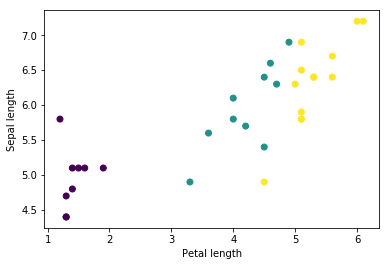

In [10]:
# Like-features are grouped together (or batched).
# Each row's fields are appended to the corresponding feature array.

# We can start to see some clusters by plotting a few features from the batch.
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");


In [11]:
# To simplify model building, create a function to repackage the
# features dictionary into a single array with shape: 
# (batch_size, num_features).

# tf.stack is used to take values from a list of tensors and creates
# a combined tensor at the specified dimension.
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels


In [12]:
# Use tf.data.Dataset.map method to pack the features of each
# (features,label) pair into the training dataset
train_dataset = train_dataset.map(pack_features_vector)


In [13]:
# look at a few examples.
features, labels = next(iter(train_dataset))

print(features[:5])


tf.Tensor(
[[7.9 3.8 6.4 2. ]
 [6.2 2.8 4.8 1.8]
 [4.5 2.3 1.3 0.3]
 [4.6 3.4 1.4 0.3]
 [5.4 3.9 1.7 0.4]], shape=(5, 4), dtype=float32)


In [16]:
# A Model is a relationship between features and the label.
# For Iris classification, the model defines the relatinship
# between the sepal and petal measurements and the predicted
# Iris species.

# Neural Network can find complex relationships between features and the label.

# Our model will yield 3 predictions when fed an unlabeled example:
# the likelihood that this flower is the given Iris species.
# This prediction is called inference.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


In [17]:
# Use the model
predictions = model(features)
predictions[:5]


<tf.Tensor: id=188, shape=(5, 3), dtype=float32, numpy=
array([[-2.14238   ,  0.2895515 , -2.1888382 ],
       [-1.6131586 ,  0.18088478, -1.6736455 ],
       [-0.36958387, -0.118213  , -0.6308155 ],
       [-0.40515295, -0.35793796, -0.66567326],
       [-0.49739438, -0.39692992, -0.7968979 ]], dtype=float32)>

In [18]:
# Currently each example returns a logit for each class.
# Logit is a vector of raw (non-normalized) predictions 
# that a classification model generates.

# To get the normalized probabilities with one value for each
# possible class, we pass it to the softmax function.
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=194, shape=(5, 3), dtype=float32, numpy=
array([[0.07498811, 0.85342795, 0.07158399],
       [0.12570672, 0.7559648 , 0.11832849],
       [0.32723695, 0.420757  , 0.25200602],
       [0.354736  , 0.37188655, 0.27337748],
       [0.3512629 , 0.3883859 , 0.26035118]], dtype=float32)>

In [19]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))


Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [2 2 0 0 0 2 0 1 1 0 0 0 1 0 1 0 1 1 0 2 1 1 2 0 2 1 0 2 2 2 0 2]


In [20]:
# Define the loss and gradient function
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.2600326538085938


In [21]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [22]:
# Create an optimizer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

In [23]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))


Step: 0, Initial Loss: 1.2600326538085938
Step: 1,         Loss: 1.1115294694900513


In [24]:
# Training Loop
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 1.054, Accuracy: 64.167%
Epoch 050: Loss: 0.436, Accuracy: 85.833%
Epoch 100: Loss: 0.273, Accuracy: 95.000%
Epoch 150: Loss: 0.177, Accuracy: 97.500%
Epoch 200: Loss: 0.127, Accuracy: 97.500%


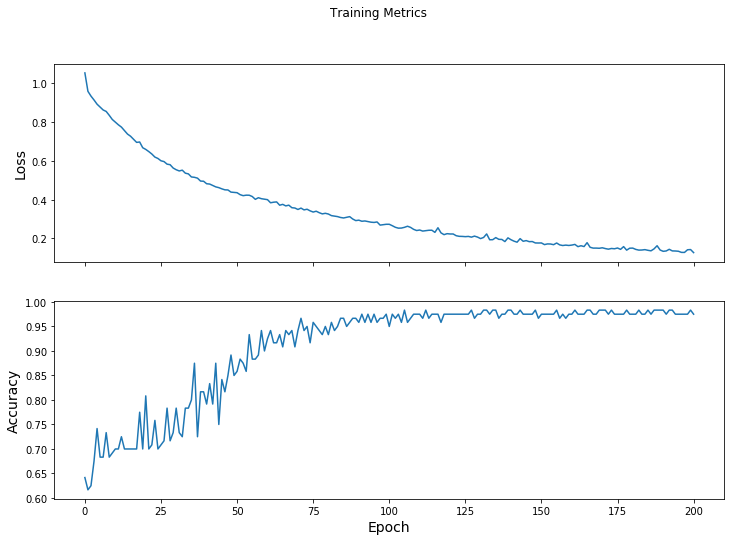

In [25]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);


In [26]:
# Setup the test dataset
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)


8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [27]:
test_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)


In [28]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


Test set accuracy: 96.667%


In [29]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=112986, shape=(24, 2), dtype=int32, numpy=
array([[0, 0],
       [2, 2],
       [1, 2],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1]])>

In [30]:
# Use trained data to test unlabeled data.
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))


Example 0 prediction: Iris setosa (96.7%)
Example 1 prediction: Iris versicolor (84.4%)
Example 2 prediction: Iris virginica (85.3%)
